In [49]:
import pandas as pd
import numpy as np
from numpy import std

import matplotlib.pyplot as plt
import datetime, time
from datetime import datetime

from google.cloud import bigquery

from sklearn.cluster import MeanShift, estimate_bandwidth, KMeans
from sklearn.preprocessing import normalize, StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score

from collections import Counter, defaultdict

from k_means_constrained import KMeansConstrained

np.set_printoptions(suppress=True)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:24: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.


In [50]:
bqclient = bigquery.Client()
query_string = """
    SELECT 
      *
    FROM `ps-analytics-prod.markus.seller_segments_20230421`
"""
seller_base_df =  bqclient.query(query_string).result().to_dataframe()


seller_base_df.shape

(729, 328)

In [51]:
seller_df = seller_base_df.copy()
seller_base_df.head()

,shop_id,shop_state,date_created,months_with_conrad,is_fds,date_first_order,days_to_first_sale,company_type,offers_active_mp_total,offers_active_mp_ict,offers_active_mp_mro,offers_active_mp_bssa,offers_active_mp_none,offers_inactive_mp_total,offers_inactive_mp_ict,offers_inactive_mp_mro,offers_inactive_mp_bssa,offers_inactive_mp_none,offers_active_oci_total,offers_active_oci_ict,offers_active_oci_mro,offers_active_oci_bssa,offers_active_oci_none,offers_inactive_oci_total,offers_inactive_oci_ict,offers_inactive_oci_mro,offers_inactive_oci_bssa,offers_inactive_oci_none,purchased_offers_mp_1m_total,purchased_offers_mp_1m_ict,purchased_offers_mp_1m_mro,purchased_offers_mp_1m_bssa,purchased_offers_mp_1m_none,purchased_offers_mp_3m_total,purchased_offers_mp_3m_ict,purchased_offers_mp_3m_mro,purchased_offers_mp_3m_bssa,purchased_offers_mp_3m_none,purchased_offers_mp_6m_total,purchased_offers_mp_6m_ict,purchased_offers_mp_6m_mro,purchased_offers_mp_6m_bssa,purchased_offers_mp_6m_none,purchased_offers_mp_12m_total,purchased_offers_mp_12m_ict,purchased_offers_mp_12m_mro,purchased_offers_mp_12m_bssa,purchased_offers_mp_12m_none,purchased_offers_oci_1m_total,purchased_offers_oci_1m_ict,purchased_offers_oci_1m_mro,purchased_offers_oci_1m_bssa,purchased_offers_oci_1m_none,purchased_offers_oci_3m_total,purchased_offers_oci_3m_ict,purchased_offers_oci_3m_mro,purchased_offers_oci_3m_bssa,purchased_offers_oci_3m_none,purchased_offers_oci_6m_total,purchased_offers_oci_6m_ict,purchased_offers_oci_6m_mro,purchased_offers_oci_6m_bssa,purchased_offers_oci_6m_none,purchased_offers_oci_12m_total,purchased_offers_oci_12m_ict,purchased_offers_oci_12m_mro,purchased_offers_oci_12m_bssa,purchased_offers_oci_12m_none,purchased_products_mp_1m_total,purchased_products_mp_1m_ict,purchased_products_mp_1m_mro,purchased_products_mp_1m_bssa,purchased_products_mp_1m_none,purchased_products_mp_3m_total,purchased_products_mp_3m_ict,purchased_products_mp_3m_mro,purchased_products_mp_3m_bssa,purchased_products_mp_3m_none,purchased_products_mp_6m_total,purchased_products_mp_6m_ict,purchased_products_mp_6m_mro,purchased_products_mp_6m_bssa,purchased_products_mp_6m_none,purchased_products_mp_12m_total,purchased_products_mp_12m_ict,purchased_products_mp_12m_mro,purchased_products_mp_12m_bssa,purchased_products_mp_12m_none,purchased_products_oci_1m_total,purchased_products_oci_1m_ict,purchased_products_oci_1m_mro,purchased_products_oci_1m_bssa,purchased_products_oci_1m_none,purchased_products_oci_3m_total,purchased_products_oci_3m_ict,purchased_products_oci_3m_mro,purchased_products_oci_3m_bssa,purchased_products_oci_3m_none,purchased_products_oci_6m_total,purchased_products_oci_6m_ict,purchased_products_oci_6m_mro,purchased_products_oci_6m_bssa,purchased_products_oci_6m_none,purchased_products_oci_12m_total,purchased_products_oci_12m_ict,purchased_products_oci_12m_mro,purchased_products_oci_12m_bssa,purchased_products_oci_12m_none,customers_mp_1m_total,customers_mp_1m_ict,customers_mp_1m_mro,customers_mp_1m_bssa,customers_mp_1m_none,customers_mp_3m_total,customers_mp_3m_ict,customers_mp_3m_mro,customers_mp_3m_bssa,customers_mp_3m_none,customers_mp_6m_total,customers_mp_6m_ict,customers_mp_6m_mro,customers_mp_6m_bssa,customers_mp_6m_none,customers_mp_12m_total,customers_mp_12m_ict,customers_mp_12m_mro,customers_mp_12m_bssa,customers_mp_12m_none,customers_oci_1m_total,customers_oci_1m_ict,customers_oci_1m_mro,customers_oci_1m_bssa,customers_oci_1m_none,customers_oci_3m_total,customers_oci_3m_ict,customers_oci_3m_mro,customers_oci_3m_bssa,customers_oci_3m_none,customers_oci_6m_total,customers_oci_6m_ict,customers_oci_6m_mro,customers_oci_6m_bssa,customers_oci_6m_none,customers_oci_12m_total,customers_oci_12m_ict,customers_oci_12m_mro,customers_oci_12m_bssa,customers_oci_12m_none,orders_mp_1m_total,orders_mp_1m_ict,orders_mp_1m_mro,orders_mp_1m_bssa,orders_mp_1m_none,orders_mp_3m_total,orders_mp_3m_ict,orders_mp_3m_mro,orders_mp_3m_bssa,orders_mp_3m_none,orders_mp_6m_total,ord

In [52]:
#percentage of missing values in each variables
missing_features = []
for col in seller_base_df.columns:
    if (seller_base_df[col].isnull().sum() / len(seller_base_df[col]) * 100 > 0):
        missing_features.append(col)
missing_features

['date_first_order', 'days_to_first_sale']

In [53]:
#data types of variables
seller_base_df.dtypes

shop_id                             Int64  
shop_state                          object 
date_created                        dbdate 
months_with_conrad                  Int64  
is_fds                              boolean
date_first_order                    dbdate 
days_to_first_sale                  Int64  
company_type                        object 
offers_active_mp_total              Int64  
offers_active_mp_ict                Int64  
offers_active_mp_mro                Int64  
offers_active_mp_bssa               Int64  
offers_active_mp_none               Int64  
offers_inactive_mp_total            Int64  
offers_inactive_mp_ict              Int64  
offers_inactive_mp_mro              Int64  
offers_inactive_mp_bssa             Int64  
offers_inactive_mp_none             Int64  
offers_active_oci_total             Int64  
offers_active_oci_ict               Int64  
offers_active_oci_mro               Int64  
offers_active_oci_bssa              Int64  
offers_active_oci_none          

In [54]:
drop_cols = ['shop_id']
boolean_cols = ['is_fds']

In [55]:
#Drop 'id' column
seller_base_df.drop(columns=drop_cols, axis=1, inplace=True)


In [56]:
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
non_numerics = ['object', 'boolean', 'dbdate']


numeric_df = seller_base_df.select_dtypes(include=numerics)
non_numerics_df = seller_base_df.select_dtypes(include=non_numerics)


for col in numeric_df.columns:
    numeric_df[col].replace({np.nan: 0}, inplace = True)


numeric_df.shape, seller_base_df.shape

/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/pandas/core/generic.py:6619: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return self._update_inplace(result)


((729, 322), (729, 327))

In [57]:
#Normalize data
normalized = normalize(numeric_df)
data_Scaled = pd.DataFrame(normalized)


In [58]:
data_Scaled.var()

0      1.864042e-01
1      3.973890e-02
2      1.345954e-02
3      3.242145e-03
4      7.956436e-03
5      1.799979e-03
6      1.034100e-05
7      2.785572e-02
8      8.435862e-03
9      1.127484e-02
10     6.022749e-03
11     9.884156e-04
12     3.601746e-04
13     7.511587e-05
14     1.991133e-04
15     3.072675e-06
16     1.415699e-08
17     9.094372e-05
18     4.885729e-05
19     2.942443e-05
20     4.325317e-07
21     1.448238e-09
22     2.152857e-07
23     5.701756e-08
24     7.547266e-08
25     6.402416e-08
26     1.123079e-09
27     1.244645e-06
28     2.511166e-07
29     5.065593e-07
30     3.432096e-07
31     3.656692e-09
32     2.575971e-06
33     6.980734e-07
34     1.154625e-06
35     5.757702e-07
36     1.102391e-08
37     5.308032e-06
38     1.675524e-06
39     2.684587e-06
40     9.157582e-07
41     1.310264e-08
42     8.601076e-09
43     2.112096e-09
44     3.353344e-09
45     2.022401e-10
46     3.688560e-13
47     6.273365e-08
48     1.879047e-08
49     2.275728e-08


In [59]:
#Storing the data variance and name of variables
variance = data_Scaled.var()
columns = numeric_df.columns

In [60]:
#Saving the names of variables having variance mre than a threshold value
variables = []
variance_threshold = 0.0025 #Setting threshold as 0.001
for i in range(0, len(variance)):
    if variance[i]> variance_threshold:
        variables.append(columns[i])

In [61]:
non_numerics_col_list = non_numerics_df.columns

In [62]:
len(variables), len(columns), len(non_numerics_col_list)

(35, 322, 5)

In [63]:
#col_list = non_numerics_col_list + variables
for x in non_numerics_col_list:
    variables.append(x)
len(variables)

40

In [64]:
#Creating new data frame with using the variables above
seller_base_df = seller_base_df[variables]
#seller_base_df_v2.shape, seller_base_df.shape
seller_base_df.shape

(729, 40)

In [65]:
seller_base_df.dtypes

months_with_conrad          Int64  
days_to_first_sale          Int64  
offers_active_mp_total      Int64  
offers_active_mp_ict        Int64  
offers_active_mp_mro        Int64  
offers_inactive_mp_total    Int64  
offers_inactive_mp_ict      Int64  
offers_inactive_mp_mro      Int64  
offers_inactive_mp_bssa     Int64  
sales_mp_3m_total           float64
sales_mp_3m_ict             float64
sales_mp_3m_mro             float64
sales_mp_3m_bssa            float64
sales_mp_6m_total           float64
sales_mp_6m_ict             float64
sales_mp_6m_mro             float64
sales_mp_6m_bssa            float64
sales_mp_12m_total          float64
sales_mp_12m_ict            float64
sales_mp_12m_mro            float64
sales_mp_12m_bssa           float64
pdp_active_6m_total         Int64  
pdp_active_6m_mro           Int64  
pdp_active_12m_total        Int64  
pdp_active_12m_ict          Int64  
pdp_active_12m_mro          Int64  
pdp_active_12m_bssa         Int64  
pdp_inactive_3m_total       

In [66]:
seller_base_df = pd.concat([seller_base_df, pd.get_dummies(seller_base_df["shop_state"],prefix="shop_state_cat")], axis=1)
seller_base_df.drop(columns=["shop_state"], axis=1, inplace=True)

seller_base_df.head()

,months_with_conrad,days_to_first_sale,offers_active_mp_total,offers_active_mp_ict,offers_active_mp_mro,offers_inactive_mp_total,offers_inactive_mp_ict,offers_inactive_mp_mro,offers_inactive_mp_bssa,sales_mp_3m_total,sales_mp_3m_ict,sales_mp_3m_mro,sales_mp_3m_bssa,sales_mp_6m_total,sales_mp_6m_ict,sales_mp_6m_mro,sales_mp_6m_bssa,sales_mp_12m_total,sales_mp_12m_ict,sales_mp_12m_mro,sales_mp_12m_bssa,pdp_active_6m_total,pdp_active_6m_mro,pdp_active_12m_total,pdp_active_12m_ict,pdp_active_12m_mro,pdp_active_12m_bssa,pdp_inactive_3m_total,pdp_inactive_6m_total,pdp_inactive_6m_ict,pdp_inactive_6m_mro,pdp_inactive_12m_total,pdp_inactive_12m_ict,pdp_inactive_12m_mro,pdp_inactive_12m_bssa,date_created,is_fds,date_first_order,company_type,shop_state_cat_CLOSE,shop_state_cat_OPEN,shop_state_cat_SUSPENDED
0,39,0,0,0,0,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2020-01-08,False,NaT,Co. KG,0,0,1
1,57,49,0,0,0,505977,10,18156,487633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,2931,7998,0,1139,13411,1,1413,11997,2018-07-27,False,2018-09-14,other,0,0,1
2,24,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2021-04-28,False,NaT,GmbH,0,0,1
3,7,0,0,0,0,2,0,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,17,19,0,0,19,0,0,19,2022-09-07,False,NaT,Co. KG,0,0,1
4,25,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2021-03-26,False,NaT,Co. KG,0,0,1


In [67]:
boolean_dict = {True: 1, False:0, "Other":99, "<NA>":99, "NA":99, "nan": 99, "NaN": 99, None: 99}
def convert_boolean_cols(df , col, boolean_dict):
    df[col].fillna("Other", inplace=True)
    df[col] = df[col].map(boolean_dict)
    return df

In [68]:
for col in boolean_cols:
    seller_base_df[col].fillna("Other", inplace=True)
    seller_base_df[col] = seller_base_df[col].map(boolean_dict)
    seller_base_df[col].value_counts()
seller_base_df['is_fds'].value_counts()

0    654
1    75 
Name: is_fds, dtype: int64

In [69]:
company_type_dictionary = dict(zip(seller_base_df['company_type'].unique() , np.arange(1, len(seller_base_df['company_type'].unique()) + 1, 1).tolist()))
seller_base_df['company_type'] = seller_base_df['company_type'].map(company_type_dictionary)
seller_base_df['company_type'].nunique()


4

In [70]:
for col in seller_base_df.select_dtypes(include=['dbdate']).columns:
    print(col)
    seller_base_df[col].replace({np.nan: '1999-01-01'}, inplace = True)
    seller_base_df[col] = pd.to_datetime(seller_base_df[col])

date_created
date_first_order


In [71]:
seller_base_df["date_created_day"] = seller_base_df['date_created'].map(lambda x: x.day)
seller_base_df["date_created_month"] = seller_base_df['date_created'].map(lambda x: x.month)
seller_base_df["date_created_year"] = seller_base_df['date_created'].map(lambda x: x.year)
seller_base_df.drop(columns=["date_created"], axis=1, inplace=True)
##############
seller_base_df["date_first_order_day"] = seller_base_df['date_first_order'].map(lambda x: x.day)
seller_base_df["date_first_order_month"] = seller_base_df['date_first_order'].map(lambda x: x.month)
seller_base_df["date_first_order_year"] = seller_base_df['date_first_order'].map(lambda x: x.year)
seller_base_df.drop(columns=["date_first_order"], axis=1, inplace=True)

In [72]:
X = seller_base_df.values
X.shape

(729, 46)

In [73]:
seller_base_df.head()

,months_with_conrad,days_to_first_sale,offers_active_mp_total,offers_active_mp_ict,offers_active_mp_mro,offers_inactive_mp_total,offers_inactive_mp_ict,offers_inactive_mp_mro,offers_inactive_mp_bssa,sales_mp_3m_total,sales_mp_3m_ict,sales_mp_3m_mro,sales_mp_3m_bssa,sales_mp_6m_total,sales_mp_6m_ict,sales_mp_6m_mro,sales_mp_6m_bssa,sales_mp_12m_total,sales_mp_12m_ict,sales_mp_12m_mro,sales_mp_12m_bssa,pdp_active_6m_total,pdp_active_6m_mro,pdp_active_12m_total,pdp_active_12m_ict,pdp_active_12m_mro,pdp_active_12m_bssa,pdp_inactive_3m_total,pdp_inactive_6m_total,pdp_inactive_6m_ict,pdp_inactive_6m_mro,pdp_inactive_12m_total,pdp_inactive_12m_ict,pdp_inactive_12m_mro,pdp_inactive_12m_bssa,is_fds,company_type,shop_state_cat_CLOSE,shop_state_cat_OPEN,shop_state_cat_SUSPENDED,date_created_day,date_created_month,date_created_year,date_first_order_day,date_first_order_month,date_first_order_year
0,39,0,0,0,0,1,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,8,1,2020,1,1,1999
1,57,49,0,0,0,505977,10,18156,487633,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,2931,7998,0,1139,13411,1,1413,11997,0,2,0,0,1,27,7,2018,14,9,2018
2,24,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,1,28,4,2021,1,1,1999
3,7,0,0,0,0,2,0,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,17,19,0,0,19,0,0,19,0,1,0,0,1,7,9,2022,1,1,1999
4,25,0,0,0,0,0,0,0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,26,3,2021,1,1,1999


In [74]:
seller_base_df.columns

Index(['months_with_conrad', 'days_to_first_sale', 'offers_active_mp_total',
       'offers_active_mp_ict', 'offers_active_mp_mro',
       'offers_inactive_mp_total', 'offers_inactive_mp_ict',
       'offers_inactive_mp_mro', 'offers_inactive_mp_bssa',
       'sales_mp_3m_total', 'sales_mp_3m_ict', 'sales_mp_3m_mro',
       'sales_mp_3m_bssa', 'sales_mp_6m_total', 'sales_mp_6m_ict',
       'sales_mp_6m_mro', 'sales_mp_6m_bssa', 'sales_mp_12m_total',
       'sales_mp_12m_ict', 'sales_mp_12m_mro', 'sales_mp_12m_bssa',
       'pdp_active_6m_total', 'pdp_active_6m_mro', 'pdp_active_12m_total',
       'pdp_active_12m_ict', 'pdp_active_12m_mro', 'pdp_active_12m_bssa',
       'pdp_inactive_3m_total', 'pdp_inactive_6m_total', 'pdp_inactive_6m_ict',
       'pdp_inactive_6m_mro', 'pdp_inactive_12m_total', 'pdp_inactive_12m_ict',
       'pdp_inactive_12m_mro', 'pdp_inactive_12m_bssa', 'is_fds',
       'company_type', 'shop_state_cat_CLOSE', 'shop_state_cat_OPEN',
       'shop_state_cat_SUSPENDED'

In [75]:
#Create the object
scaler = StandardScaler()
#Calculate the mean and standart deviasion
scaler.fit(X)
#Transform the values
X_scaled = scaler.transform(X)


In [76]:
X_scaled.shape

(729, 46)

In [77]:
pca_137 = PCA(n_components=X_scaled.shape[1], random_state=2020)
pca_137.fit(X_scaled)
X_pca_137 = pca_137.transform(X_scaled)

In [78]:
print("Variance explained by all feature's principal components = ",
      sum(pca_137.explained_variance_ratio_ * 100))

Variance explained by all feature's principal components =  99.99999999999997


In [79]:
X_pca_137.shape

(729, 46)

In [80]:
np.average(X_pca_137,  axis=0)

array([ 0.,  0., -0., -0., -0.,  0., -0.,  0.,  0., -0., -0., -0.,  0.,
        0.,  0.,  0.,  0., -0., -0.,  0., -0.,  0.,  0.,  0.,  0., -0.,
       -0.,  0., -0.,  0.,  0.,  0., -0., -0.,  0.,  0., -0., -0.,  0.,
       -0.,  0., -0., -0., -0.,  0.,  0.])

In [81]:
pca_137.explained_variance_ratio_ * 100

array([37.07935231, 17.75948881,  8.60560332,  7.22179817,  4.21653421,
        3.55429502,  2.43183111,  2.30165002,  2.22797048,  2.10404733,
        1.91938909,  1.62621634,  1.45638781,  1.37627212,  1.19509222,
        1.07141314,  0.92871757,  0.75340729,  0.64988824,  0.43683774,
        0.42807534,  0.39579021,  0.11782018,  0.03996188,  0.02945499,
        0.0235587 ,  0.01583779,  0.01282277,  0.01098607,  0.00376223,
        0.00348859,  0.00194217,  0.00011176,  0.00007259,  0.00005324,
        0.00002866,  0.00001796,  0.00001024,  0.00000865,  0.00000228,
        0.0000008 ,  0.00000037,  0.00000019,  0.00000001,  0.        ,
        0.        ])

In [82]:
np.cumsum(pca_137.explained_variance_ratio_ * 100)

array([ 37.07935231,  54.83884112,  63.44444443,  70.6662426 ,
        74.88277681,  78.43707183,  80.86890294,  83.17055296,
        85.39852344,  87.50257078,  89.42195987,  91.0481762 ,
        92.50456401,  93.88083613,  95.07592834,  96.14734149,
        97.07605906,  97.82946635,  98.4793546 ,  98.91619234,
        99.34426768,  99.74005789,  99.85787807,  99.89783995,
        99.92729494,  99.95085364,  99.96669143,  99.97951419,
        99.99050026,  99.9942625 ,  99.99775109,  99.99969326,
        99.99980502,  99.99987761,  99.99993084,  99.99995951,
        99.99997746,  99.9999877 ,  99.99999635,  99.99999863,
        99.99999943,  99.9999998 ,  99.99999999, 100.        ,
       100.        , 100.        ])

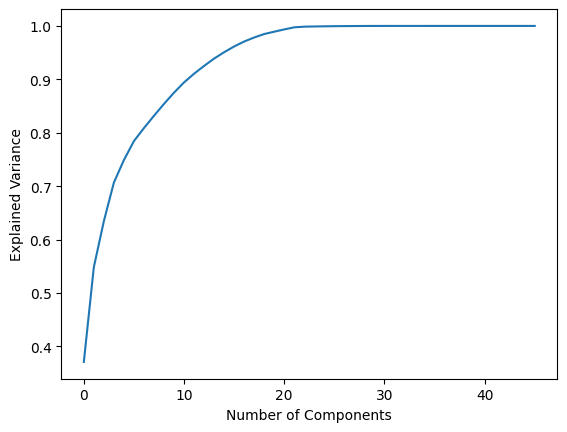

In [83]:
plt.plot(np.cumsum(pca_137.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance")
plt.savefig("elbow_plot.png", dpi=100)

In [84]:
X_scaled = StandardScaler().fit_transform(seller_base_df)


In [85]:
X_scaled[:5]


array([[ 0.59050554, -0.6513746 , -0.2216587 , -0.15293958, -0.19923374,
        -0.09419261, -0.06489211, -0.12939296, -0.13154415, -0.18628399,
        -0.12306306, -0.20885968, -0.21218367, -0.1890005 , -0.12562653,
        -0.20194188, -0.20870729, -0.17844404, -0.11989499, -0.19336356,
        -0.20011578, -0.14920368, -0.13852691, -0.14849495, -0.15123186,
        -0.13799818, -0.12039541, -0.05954537, -0.05914989, -0.05247986,
        -0.11736951, -0.05902143, -0.05249811, -0.11615572, -0.06245295,
        -0.33864273, -2.30520651, -0.15451992, -1.44081552,  1.52106422,
        -0.89803358, -1.70470376, -0.26141349, -1.01068537, -1.02181672,
        -1.45147885],
       [ 1.65560708, -0.32272475, -0.2216587 , -0.15293958, -0.19923374,
         0.94834841, -0.06486535,  0.02468349, 12.41416912, -0.18628399,
        -0.12306306, -0.20885968, -0.21218367, -0.1890005 , -0.12562653,
        -0.20194188, -0.20870729, -0.17844404, -0.11989499, -0.19336356,
        -0.20011578, -0.14920

In [86]:
features = X_scaled.T
cov_matrix = np.cov(features)
cov_matrix[:5]

array([[ 1.00137363,  0.10571878,  0.15894186,  0.08876393,  0.15236739,
         0.03889911,  0.0083248 ,  0.08988378,  0.1113321 ,  0.05982513,
         0.00254576,  0.15409664,  0.09530768,  0.05935598,  0.0004599 ,
         0.15515416,  0.09298442,  0.06602105,  0.00627294,  0.16398264,
         0.10378328,  0.03589565,  0.06361208,  0.03509086,  0.01181873,
         0.06257702,  0.02735191,  0.00263463,  0.00235582, -0.00035624,
         0.03138757,  0.00235494, -0.00031494,  0.03013846,  0.00409195,
         0.12426261,  0.08055316,  0.05366961,  0.07337896, -0.09252369,
         0.06348898,  0.01649201, -0.98391387,  0.24269707,  0.20115066,
         0.15930908],
       [ 0.10571878,  1.00137363,  0.01907407,  0.02757555,  0.01910744,
         0.00204559,  0.0063468 , -0.0047845 , -0.0166059 , -0.000985  ,
        -0.00511332,  0.01005125,  0.00075113, -0.00587385, -0.00787686,
         0.00558494, -0.00939804, -0.0088648 , -0.00986247,  0.00326165,
        -0.01360117, -0.00885

In [87]:
values, vectors = np.linalg.eig(cov_matrix)
values[:5]

array([17.07993132,  8.18058651,  3.96401513,  3.32659038,  1.94227003])

In [88]:
explained_variances = []
for i in range(len(values)):
    explained_variances.append(values[i] / np.sum(values))
 
print(np.sum(explained_variances), '\n', explained_variances)

0.9999999999999996 
 [0.3707935230936094, 0.17759488805915433, 0.08605603316901093, 0.07221798165163666, 0.042165342123147605, 0.03554295021195925, 0.024318311129249513, 0.02301650016646644, 0.022279704842518486, 0.02104047332695921, 0.019193890901443654, 0.016262163361322565, 0.014563878079225767, 0.013762721171129694, 0.011950922161300752, 0.010714131414337275, 0.009287175743036774, 0.007534072942293816, 0.006498882408341652, 0.0039579021290700196, 0.0042807534246085575, 0.00436837742553321, 0.0011782017832630647, 0.0003996187731254188, 0.0002945499373379516, 0.0002355869580606032, 0.00015837787646456124, 0.000128227675924381, 0.00010986068920438883, 3.7622337223379205e-05, 3.4885938468229156e-05, 1.9421691123273543e-05, 1.1175688187887955e-06, 7.258983346405497e-07, 5.323657345296158e-07, 2.866349580010992e-07, 1.7956166171438191e-07, 1.0242414430476895e-07, 8.646850511963155e-08, 2.2773667170618997e-08, 7.983842957589512e-09, 3.715681496914817e-09, 1.94136378159462e-09, 6.773642193

In [89]:
class color:
   BOLD = '\033[1m'
   END = '\033[0m'

In [90]:
seller_base_df.shape

(729, 46)

In [91]:
clf_5 = KMeansConstrained(
             n_clusters=5,
             size_min=20,
             size_max=170,
             random_state=20
)
clf_5.fit_predict(seller_base_df)
#print(color.BOLD + str(k) + color.END)
print(Counter(clf_5.labels_))
silhouette_avg_kmeans = silhouette_score(seller_base_df, clf_5.labels_)
print(color.BOLD + "For n_clusters =", str(clf_5.labels_.max() + 1) + color.END, "The average silhouette_score is :", silhouette_avg_kmeans)

Counter({1: 170, 2: 170, 3: 170, 4: 170, 0: 49})
For n_clusters = 5 The average silhouette_score is : -0.11685893831151632


In [92]:
clf_6 = KMeansConstrained(
             n_clusters=6,
             size_min=20,
             size_max=170,
             random_state=20
)
clf_6.fit_predict(seller_base_df)
#print(color.BOLD + str(k) + color.END)
print(Counter(clf_6.labels_))
silhouette_avg_kmeans = silhouette_score(seller_base_df, clf_6.labels_)
print(color.BOLD + "For n_clusters =", str(clf_6.labels_.max() + 1) + color.END, "The average silhouette_score is :", silhouette_avg_kmeans)

Counter({2: 170, 5: 170, 3: 170, 4: 170, 0: 26, 1: 23})
For n_clusters = 6 The average silhouette_score is : -0.2025771319176032


In [93]:
clf_7 = KMeansConstrained(
             n_clusters=7,
             size_min=20,
             size_max=170,
             random_state=20
)
clf_7.fit_predict(seller_base_df)
#print(color.BOLD + str(k) + color.END)
print(Counter(clf_7.labels_))
silhouette_avg_kmeans = silhouette_score(seller_base_df, clf_7.labels_)
print(color.BOLD + "For n_clusters =", str(clf_7.labels_.max() + 1) + color.END, "The average silhouette_score is :", silhouette_avg_kmeans)

Counter({2: 170, 0: 170, 6: 170, 4: 153, 1: 26, 3: 20, 5: 20})
For n_clusters = 7 The average silhouette_score is : -0.18104598768592126


In [94]:
#seller_base_df['seller_segments'] = clf.labels_
seller_df_5 = seller_df.copy()
seller_df_5['seller_segments'] = clf_5.labels_

seller_df_6 = seller_df.copy()
seller_df_6['seller_segments'] = clf_6.labels_

seller_df_7 = seller_df.copy()
seller_df_7['seller_segments'] = clf_7.labels_



/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:6: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  
/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/ipykernel_launcher.py:9: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, w

In [95]:
# TODO(developer): Set table_id to the ID of the table to fetch.

table_id_5 = 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_5'
table_id_6 = 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_6'
table_id_7 = 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_7'

table_list = [table_id_5, table_id_6, table_id_7]
seller_list = [seller_df_5, seller_df_6, seller_df_7]

for table in table_list:
    bqclient.delete_table(table, not_found_ok=True)  # Make an API request.
    print("Deleted table '{}'.".format(table))
    
# Load data to BQ
job = bqclient.load_table_from_dataframe(seller_df_5, table_id_5)
print("Table created '{}'.".format(table_id_5))

job = bqclient.load_table_from_dataframe(seller_df_6, table_id_6)
print("Table created '{}'.".format(table_id_6))

job = bqclient.load_table_from_dataframe(seller_df_7, table_id_7)
print("Table created '{}'.".format(table_id_7))



Deleted table 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_5'.
Deleted table 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_6'.
Deleted table 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_7'.


/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/google/cloud/bigquery/_pandas_helpers.py:484: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  sample_data = _first_valid(dataframe.reset_index()[column])
/opt/conda/envs/jupyterlab/lib/python3.7/site-packages/google/cloud/bigquery/_pandas_helpers.py:547: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  arrow_table = pyarrow.array(dataframe.reset_index()[field.name])


Table created 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_5'.
Table created 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_6'.
Table created 'ps-analytics-prod.eser.seller_segment_results_iteration_3_k_7'.
